In [18]:
import pandas as pd
pd.set_option('display.max_row', 500)
pd.set_option('display.max_columns', 100)
import numpy as np
import matplotlib.pyplot as plt  # 그래프 그리는 라이브러리
from sklearn.model_selection import train_test_split
from sklearn import metrics  # 평가를 위한 라이브러리
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

import seaborn as sns  # 시각화 라이브러리

In [19]:
train = pd.read_csv('data/train.csv', index_col = 'day_text')
test = pd.read_csv('data/test.csv', index_col = 'day_text')

In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7000 entries, 4.7 to 7.7
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   team_text    7000 non-null   object 
 1   H_text       7000 non-null   int64  
 2   HR_text      7000 non-null   int64  
 3   S_text       7000 non-null   int64  
 4   ST_text      7000 non-null   int64  
 5   DU_text      7000 non-null   int64  
 6   ER_text      7000 non-null   int64  
 7   result_text  7000 non-null   int64  
 8   location     7000 non-null   object 
 9   temp         7000 non-null   float64
 10  rain         7000 non-null   float64
 11  humidity     7000 non-null   float64
dtypes: float64(3), int64(7), object(2)
memory usage: 710.9+ KB


In [21]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3398 entries, 7.7 to 10.26토
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   team_text    3398 non-null   object 
 1   H_text       3398 non-null   int64  
 2   HR_text      3398 non-null   int64  
 3   S_text       3398 non-null   int64  
 4   ST_text      3398 non-null   int64  
 5   DU_text      3398 non-null   int64  
 6   ER_text      3398 non-null   int64  
 7   result_text  3398 non-null   int64  
 8   location     3398 non-null   object 
 9   temp         3398 non-null   float64
 10  rain         3398 non-null   float64
 11  humidity     3398 non-null   int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 345.1+ KB


In [15]:
train.corr()

,H_text,HR_text,S_text,ST_text,DU_text,ER_text,result_text,temp,rain,humidity
H_text,1.000000,0.381357,0.109626,-0.107799,0.080418,-0.002447,0.411615,0.067297,0.002754,0.006877
HR_text,0.381357,1.000000,-0.020410,0.009257,-0.045893,-0.019503,0.267704,0.050888,-0.024830,0.052948
S_text,0.109626,-0.020410,1.000000,0.024302,-0.070301,-0.023027,0.168250,-0.003281,-0.000741,-0.037783
ST_text,-0.107799,0.009257,0.024302,1.000000,-0.174138,0.042208,-0.177470,-0.068097,0.001156,0.051873
DU_text,0.080418,-0.045893,-0.070301,-0.174138,1.000000,0.014275,-0.079218,-0.003311,-0.005420,0.006083
ER_text,-0.002447,-0.019503,-0.023027,0.042208,0.014275,1.000000,-0.172610,-0.034883,-0.012892,-0.031010
result_text,0.411615,0.267704,0.168250,-0.177470,-0.079218,-0.172610,1.000000,0.000000,0.000000,0.000000
temp,0.067297,0.050888,-0.003281,-0.068097,-0.003311,-0.034883,0.000000,1.000000,-0.006105,-0.180981
rain,0.002754,-0.024830,-0.000741,0.001156,-0.005420,-0.012892,0.000000,-0.006105,1.000000,0.012211
humidity,0.006877,0.052948,-0.037783,0.051873,0.006083,-0.031010,0.000000,-0.180981,0.012211,1.000000


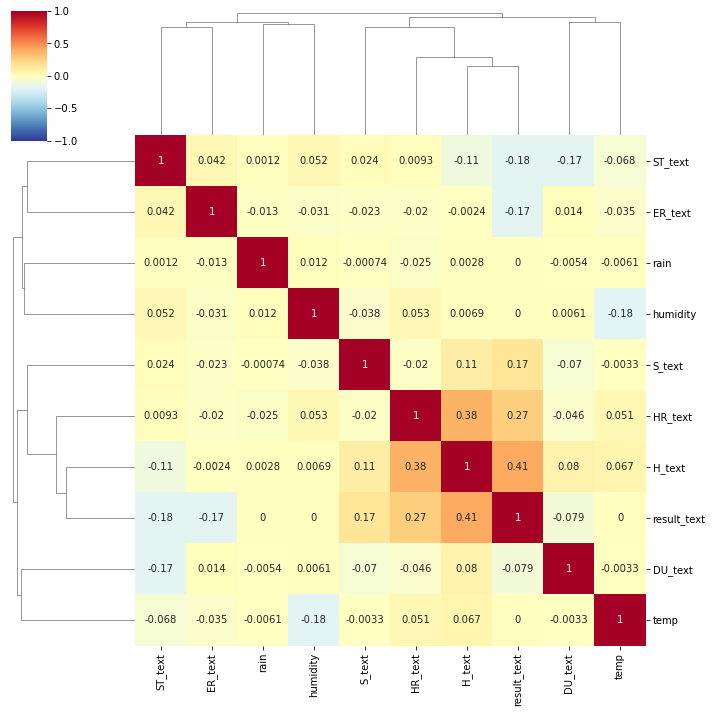

In [150]:
sns.clustermap(train.corr(), 
               annot = True,      # 실제 값 화면에 나타내기
               cmap = 'RdYlBu_r',  # Red, Yellow, Blue 색상으로 표시
               vmin = -1, vmax = 1, #컬러차트 -1 ~ 1 범위로 표시
              )

### 데이터 탐색(result_text 의 빈도가 높은 경우를 찾기)

In [6]:
test_result = test[['team_text', 'result_text', 'location']].groupby(['team_text','result_text']).count()
test_result

location
team_text result_text          
KIA 타이거즈  0                 176
          1                 163
LG 트윈스    0                 168
          1                 173
NC 다이노스   0                 186
          1                 157
SK 와이번스   0                 153
          1                 186
kt wiz    0                 185
          1                 147
두산 베어스    0                 127
          1                 222
롯데 자이언츠   0                 177
          1                 157
삼성 라이온즈   0                 181
          1                 147
키움 히어로즈   0                 163
          1                 190
한화 이글스    0                 183
          1                 157

### 온도 5도 기준으로 나눠서 시각화
- 어느 온도에서 야구 경기가 많이 이루어졌는지 볼 수 있음

In [7]:
bins = [5,11,16,21,26,31,36,41]  # 구간 만들기
labels = ['5~10', '10~15', '15~20', '20~25', '25~30', '30~35', '35~40']
train['temp'] = pd.cut(train['temp'], bins = bins, labels = labels)
test['temp'] = pd.cut(test['temp'], bins = bins, labels = labels)

<AxesSubplot:xlabel='temp', ylabel='count'>

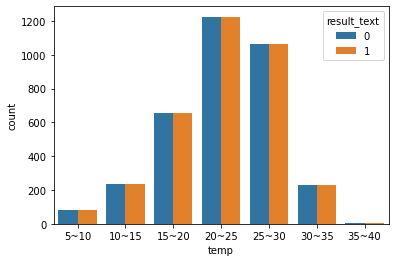

In [8]:
sns.countplot(data = train, x = 'temp', hue='result_text')

In [ ]:
titanic_size = titanic.pivot_table(
    index="class", columns="sex", aggfunc="size")
titanic_size

### 강수량 3mm 를 기준으로 나눠서 시각화

In [22]:
bins = [0,4,7,10,13,16,19]  # 구간 만들기
labels = ['0~3', '3~6', '6~9', '9~12', '12~15', '15~18']
train['rain'] = pd.cut(train['rain'], bins = bins, labels = labels)
test['rain'] = pd.cut(test['rain'], bins = bins, labels = labels)

<AxesSubplot:xlabel='rain', ylabel='count'>

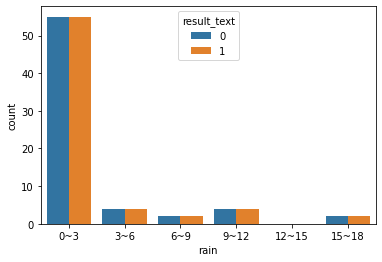

In [23]:
sns.countplot(data = train, x = 'rain', hue='result_text')

### 습도 10% 를 기준으로 나눠서 시각화

In [11]:
bins = [-1,11,21,31,41,51,61,71,81,91,101]  # 구간 만들기
labels = ['0~10', '10~20', '20~30', '30~40', '40~50', '50~60', '60~70', '70~80', '80~90', '90~100']
train['humidity'] = pd.cut(train['humidity'], bins = bins, labels = labels)
test['humidity'] = pd.cut(test['humidity'], bins = bins, labels = labels)

<AxesSubplot:xlabel='humidity', ylabel='count'>

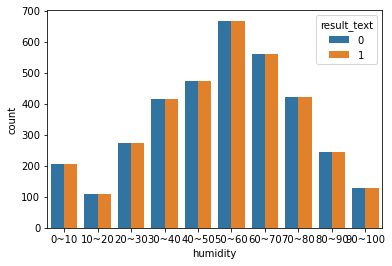

In [12]:
sns.countplot(data = train, x = 'humidity', hue='result_text')

### 일단 팀 구별 없이 데이터 넣고 모델 돌려보기
- 팀 이름 데이터와 location 데이터 drop

* 위에서 부터 실행 시킬때 카테고리화 되기 때문에 데이터 다시 불러와야함

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7000 entries, 4.7 to 7.7
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   team_text    7000 non-null   object 
 1   H_text       7000 non-null   int64  
 2   HR_text      7000 non-null   int64  
 3   S_text       7000 non-null   int64  
 4   ST_text      7000 non-null   int64  
 5   DU_text      7000 non-null   int64  
 6   ER_text      7000 non-null   int64  
 7   result_text  7000 non-null   int64  
 8   location     7000 non-null   object 
 9   temp         7000 non-null   float64
 10  rain         7000 non-null   float64
 11  humidity     7000 non-null   float64
dtypes: float64(3), int64(7), object(2)
memory usage: 710.9+ KB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3398 entries, 7.7 to 10.26토
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   team_text    3398 non-null   object 
 1   H_text       3398 non-null   int64  
 2   HR_text      3398 non-null   int64  
 3   S_text       3398 non-null   int64  
 4   ST_text      3398 non-null   int64  
 5   DU_text      3398 non-null   int64  
 6   ER_text      3398 non-null   int64  
 7   result_text  3398 non-null   int64  
 8   location     3398 non-null   object 
 9   temp         3398 non-null   float64
 10  rain         3398 non-null   float64
 11  humidity     3398 non-null   int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 345.1+ KB


In [8]:
train.drop('team_text', axis = 1 , inplace = True)
test.drop('team_text', axis = 1 , inplace = True)

In [9]:
train.drop('location', axis = 1 , inplace = True)
test.drop('location', axis = 1 , inplace = True)

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7000 entries, 4.7 to 7.7
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   H_text       7000 non-null   int64  
 1   HR_text      7000 non-null   int64  
 2   S_text       7000 non-null   int64  
 3   ST_text      7000 non-null   int64  
 4   DU_text      7000 non-null   int64  
 5   ER_text      7000 non-null   int64  
 6   result_text  7000 non-null   int64  
 7   temp         7000 non-null   float64
 8   rain         7000 non-null   float64
 9   humidity     7000 non-null   float64
dtypes: float64(3), int64(7)
memory usage: 601.6+ KB


In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3398 entries, 7.7 to 10.26토
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   H_text       3398 non-null   int64  
 1   HR_text      3398 non-null   int64  
 2   S_text       3398 non-null   int64  
 3   ST_text      3398 non-null   int64  
 4   DU_text      3398 non-null   int64  
 5   ER_text      3398 non-null   int64  
 6   result_text  3398 non-null   int64  
 7   temp         3398 non-null   float64
 8   rain         3398 non-null   float64
 9   humidity     3398 non-null   int64  
dtypes: float64(2), int64(8)
memory usage: 292.0+ KB


#### train 과 test 데이터 설정

In [12]:
y_train = train['result_text']
X_train = train.drop('result_text', axis = 1)
y_test = test['result_text']
X_test = test.drop('result_text', axis = 1)

### KNN 모델

In [23]:
knn_model = KNeighborsClassifier(n_neighbors = 50)
result = cross_val_score(knn_model,
                        X_train,
                        y_train,
                        cv = 5)
result

array([0.70714286, 0.71285714, 0.72      , 0.70642857, 0.69714286])

In [24]:
result.mean()

0.7087142857142856

#### KNN Scaler 적용

In [25]:
scaler = StandardScaler()

In [26]:
scaler.fit(X_train)  # 평균과 표준편차로 scaling 한 값을 컴퓨터가 기억

StandardScaler()

In [27]:
transform_X_train = scaler.transform(X_train)
transform_X_train

array([[ 0.39440379, -0.86226809,  1.10850335, ..., -0.37077158,
        -0.27374911, -0.19483241],
       [ 0.12547465,  0.09186985,  1.10850335, ..., -0.37077158,
        -0.27374911, -0.19483241],
       [-0.95024191, -0.86226809,  1.10850335, ..., -0.37077158,
        -0.27374911, -0.19483241],
       ...,
       [-0.41238363, -0.86226809, -0.784987  , ..., -0.37077158,
        -0.27374911,  5.13261629],
       [ 0.39440379,  2.9542837 , -0.784987  , ..., -0.37077158,
        -0.27374911,  5.13261629],
       [-0.14345449,  0.09186985, -0.784987  , ..., -0.37077158,
        -0.27374911,  5.13261629]])

In [28]:
transform_X_test = scaler.transform(X_test)
transform_X_test

array([[ 1.20119121,  2.00014575, -0.784987  , ...,  2.69707836,
        -0.27374911, -0.19483241],
       [ 0.12547465, -0.86226809, -0.784987  , ...,  2.69707836,
        -0.27374911, -0.19483241],
       [ 0.39440379,  0.09186985,  0.16175818, ...,  2.69707836,
        -0.27374911, -0.19483241],
       ...,
       [-1.48810019, -0.86226809, -0.784987  , ..., -0.37077158,
        -0.27374911, -0.19483241],
       [ 1.20119121, -0.86226809,  0.16175818, ..., -0.37077158,
        -0.27374911, -0.19483241],
       [ 0.66333293, -0.86226809, -0.784987  , ..., -0.37077158,
        -0.27374911, -0.19483241]])

In [29]:
result = cross_val_score(knn_model,
                        transform_X_train,
                        y_train,
                        cv = 5)
result

array([0.67571429, 0.70142857, 0.7       , 0.70857143, 0.68785714])

In [30]:
result.mean()

0.6947142857142857

#### KNN Scaler 적용

In [31]:
y_pred = knn_model.fit(transform_X_train, y_train).predict(transform_X_test)

In [32]:
print("총 승패 갯수 %d 에서 틀린 예측 갯수 : %d" % (transform_X_test.shape[0], (y_test != y_pred).sum()))

총 승패 갯수 3398 에서 틀린 예측 갯수 : 1030


In [33]:
print("예측 정확도: {:.2f}".format(np.mean(y_pred == y_test)))

예측 정확도: 0.70


### Decision Tree 모델

In [34]:
tree_model = DecisionTreeClassifier(max_depth = 7)

In [35]:
result = cross_val_score(tree_model,
                        X_train,
                        y_train,
                        cv = 10)
result

array([0.68      , 0.67571429, 0.69      , 0.66285714, 0.68      ,
       0.71428571, 0.69142857, 0.69428571, 0.67      , 0.70714286])

In [36]:
result.mean()

0.6865714285714286

In [37]:
y_pred = tree_model.fit(X_train, y_train).predict(X_test)

In [38]:
print("총 승패 갯수 %d 에서 틀린 예측 갯수 : %d" % (X_test.shape[0], (y_test != y_pred).sum()))

총 승패 갯수 3398 에서 틀린 예측 갯수 : 1013


In [39]:
print("예측 정확도: {:.2f}".format(np.mean(y_pred == y_test)))

예측 정확도: 0.70


### Random Forest

In [157]:
from sklearn.ensemble import RandomForestClassifier

In [158]:
rf_clf = RandomForestClassifier()
model = rf_clf.fit(X_train,y_train)
rf_pred = model.predict(X_test)
print("총 승패 갯수 %d 에서 틀린 예측 갯수 : %d" % (X_test.shape[0], (y_test != rf_pred).sum()))
print("예측 정확도: {:.2f}".format(np.mean(rf_pred == y_test)))

총 승패 갯수 3398 에서 틀린 예측 갯수 : 1003
예측 정확도: 0.70


### Naive Bayes 분류 모델

In [40]:
from sklearn.naive_bayes import GaussianNB

In [41]:
nb = GaussianNB()

In [42]:
y_pred = nb.fit(X_train, y_train).predict(X_test)

In [43]:
print("총 승패 갯수 %d 에서 틀린 예측 갯수 : %d" % (X_test.shape[0], (y_test != y_pred).sum()))

총 승패 갯수 3398 에서 틀린 예측 갯수 : 1010


In [44]:
print("예측 정확도: {:.2f}".format(np.mean(y_pred == y_test)))

예측 정확도: 0.70


### SVM 분류 모델

In [45]:
svm_model = SVC(kernel='rbf', C=1000, gamma=0.001)

In [46]:
y_pred = svm_model.fit(X_train, y_train).predict(X_test)

In [47]:
print("총 승패 갯수 %d 에서 틀린 예측 갯수 : %d" % (X_test.shape[0], (y_test != y_pred).sum()))

총 승패 갯수 3398 에서 틀린 예측 갯수 : 965


In [48]:
print("예측 정확도: {:.2f}".format(np.mean(y_pred == y_test)))

예측 정확도: 0.72


### XGBOOST 모델

In [49]:
from xgboost import plot_importance
from xgboost import XGBClassifier

In [50]:
xgb = XGBClassifier(n_estimators = 5000, learning_rate = 0.001, max_depth = 5)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

C:\Users\smhrd\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:14:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [51]:
print("총 승패 갯수 %d 에서 틀린 예측 갯수 : %d" % (X_test.shape[0], (y_test != xgb_pred).sum()))

총 승패 갯수 3398 에서 틀린 예측 갯수 : 957


In [52]:
print("예측 정확도: {:.2f}".format(np.mean(xgb_pred == y_test)))

예측 정확도: 0.72


### Stochastic Gradient Descent

In [53]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [54]:
sgd =  SGDClassifier(loss='modified_huber', shuffle=True,random_state=101)
sgd.fit(X_train, y_train)
y_pred=sgd.predict(X_test)

In [55]:
print("총 승패 갯수 %d 에서 틀린 예측 갯수 : %d" % (X_test.shape[0], (y_test != y_pred).sum()))

총 승패 갯수 3398 에서 틀린 예측 갯수 : 1153


In [56]:
print("예측 정확도: {:.2f}".format(np.mean(y_pred == y_test)))

예측 정확도: 0.66


### 모델 한번에

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.utils import shuffle

In [58]:
train_data, train_label = shuffle(X_train, y_train, random_state = 5)

In [59]:
def train_and_test(model):
    model.fit(train_data, train_label)
    prediction = model.predict(X_test)
    accuracy = round(model.score(train_data, train_label) * 100, 2)
    print("Accuracy : ", accuracy, "%")
    return prediction

In [60]:
# Logistic Regression
log_pred = train_and_test(LogisticRegression())
# SVM
svm_pred = train_and_test(SVC())
#kNN
knn_pred_4 = train_and_test(KNeighborsClassifier(n_neighbors = 4))
# Random Forest
rf_pred = train_and_test(RandomForestClassifier(n_estimators=100))
# Navie Bayes
nb_pred = train_and_test(GaussianNB())

Accuracy :  72.61 %


C:\Users\smhrd\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy :  72.53 %
Accuracy :  77.73 %
Accuracy :  99.21 %
Accuracy :  70.43 %


In [61]:
print("총 승패 갯수 %d 에서 틀린 예측 갯수 : %d" % (X_test.shape[0], (y_test != log_pred).sum()))

총 승패 갯수 3398 에서 틀린 예측 갯수 : 946


In [62]:
print("예측 정확도: {:.2f}".format(np.mean(log_pred == y_test)))

예측 정확도: 0.72


### Keras

In [109]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7000 entries, 4.7 to 7.7
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   H_text       7000 non-null   float64
 1   HR_text      7000 non-null   float64
 2   S_text       7000 non-null   float64
 3   ST_text      7000 non-null   float64
 4   DU_text      7000 non-null   float64
 5   ER_text      7000 non-null   float64
 6   result_text  7000 non-null   float64
 7   temp         7000 non-null   float64
 8   rain         7000 non-null   float64
 9   humidity     7000 non-null   float64
dtypes: float64(10)
memory usage: 601.6+ KB


In [110]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3398 entries, 7.7 to 10.26토
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   H_text       3398 non-null   float64
 1   HR_text      3398 non-null   float64
 2   S_text       3398 non-null   float64
 3   ST_text      3398 non-null   float64
 4   DU_text      3398 non-null   float64
 5   ER_text      3398 non-null   float64
 6   result_text  3398 non-null   float64
 7   temp         3398 non-null   float64
 8   rain         3398 non-null   float64
 9   humidity     3398 non-null   float64
dtypes: float64(10)
memory usage: 292.0+ KB


In [111]:
train['H_text'] = train['H_text'].astype('float')
train['HR_text'] = train['HR_text'].astype('float')
train['S_text'] = train['S_text'].astype('float')
train['ST_text'] = train['ST_text'].astype('float')
train['DU_text'] = train['DU_text'].astype('float')
train['ER_text'] = train['ER_text'].astype('float')
train['result_text'] = train['result_text'].astype('float')

In [112]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7000 entries, 4.7 to 7.7
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   H_text       7000 non-null   float64
 1   HR_text      7000 non-null   float64
 2   S_text       7000 non-null   float64
 3   ST_text      7000 non-null   float64
 4   DU_text      7000 non-null   float64
 5   ER_text      7000 non-null   float64
 6   result_text  7000 non-null   float64
 7   temp         7000 non-null   float64
 8   rain         7000 non-null   float64
 9   humidity     7000 non-null   float64
dtypes: float64(10)
memory usage: 601.6+ KB


In [113]:
test['H_text'] = test['H_text'].astype('float')
test['HR_text'] = test['HR_text'].astype('float')
test['S_text'] = test['S_text'].astype('float')
test['ST_text'] = test['ST_text'].astype('float')
test['DU_text'] = test['DU_text'].astype('float')
test['ER_text'] = test['ER_text'].astype('float')
test['result_text'] = test['result_text'].astype('float')
test['humidity'] = test['humidity'].astype('float')

In [114]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3398 entries, 7.7 to 10.26토
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   H_text       3398 non-null   float64
 1   HR_text      3398 non-null   float64
 2   S_text       3398 non-null   float64
 3   ST_text      3398 non-null   float64
 4   DU_text      3398 non-null   float64
 5   ER_text      3398 non-null   float64
 6   result_text  3398 non-null   float64
 7   temp         3398 non-null   float64
 8   rain         3398 non-null   float64
 9   humidity     3398 non-null   float64
dtypes: float64(10)
memory usage: 292.0+ KB


In [127]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers.core import Dense,Dropout

model = Sequential()


#model.add(Dense(255, activation='relu', input_shape=(1,9)))
model.add(Dense(300, activation='relu', input_shape=(1,9)))
model.add(Dense(200, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

In [128]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [141]:
model.fit(X_train, y_train, epochs=15, batch_size=20, verbose=1)

Epoch 1/15
350/350 [==============================] - 0s 903us/step - loss: 0.5097 - accuracy: 0.7394
Epoch 2/15
350/350 [==============================] - 0s 910us/step - loss: 0.5049 - accuracy: 0.7434
Epoch 3/15
350/350 [==============================] - 0s 1ms/step - loss: 0.5080 - accuracy: 0.7390
Epoch 4/15
350/350 [==============================] - 0s 908us/step - loss: 0.5041 - accuracy: 0.7420
Epoch 5/15
350/350 [==============================] - 0s 1ms/step - loss: 0.5057 - accuracy: 0.7400
Epoch 6/15
350/350 [==============================] - 0s 958us/step - loss: 0.5056 - accuracy: 0.7404
Epoch 7/15
350/350 [==============================] - 0s 884us/step - loss: 0.5051 - accuracy: 0.7421
Epoch 8/15
350/350 [==============================] - 0s 910us/step - loss: 0.5086 - accuracy: 0.7413
Epoch 9/15
350/350 [==============================] - 0s 1ms/step - loss: 0.5015 - accuracy: 0.7440
Epoch 10/15
350/350 [==============================] - 0s 895us/step - loss: 0.5040 - ac

In [145]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print('\ntest accuracy:', test_acc)

107/107 [==============================] - 0s 529us/step - loss: 0.6413 - accuracy: 0.7075

test accuracy: 0.7074750065803528


In [148]:
model = model.fit(X_train, y_train, epochs=15, batch_size=20, verbose=1)

Epoch 1/15
350/350 [==============================] - 0s 973us/step - loss: 0.5370 - accuracy: 0.7281
Epoch 2/15
350/350 [==============================] - 0s 897us/step - loss: 0.5320 - accuracy: 0.7276
Epoch 3/15
350/350 [==============================] - 0s 974us/step - loss: 0.5318 - accuracy: 0.7287
Epoch 4/15
350/350 [==============================] - 0s 925us/step - loss: 0.5310 - accuracy: 0.7303
Epoch 5/15
350/350 [==============================] - 0s 961us/step - loss: 0.5305 - accuracy: 0.7290
Epoch 6/15
350/350 [==============================] - 0s 966us/step - loss: 0.5299 - accuracy: 0.7299
Epoch 7/15
350/350 [==============================] - 0s 900us/step - loss: 0.5299 - accuracy: 0.7300
Epoch 8/15
350/350 [==============================] - 0s 1ms/step - loss: 0.5292 - accuracy: 0.7279
Epoch 9/15
350/350 [==============================] - 0s 949us/step - loss: 0.5290 - accuracy: 0.7297
Epoch 10/15
350/350 [==============================] - 0s 1ms/step - loss: 0.5280 - 